### This notebook is designed to make a Dataframe with rear events that are borderless and associate the beacon location with it
It will center all positions and rotate beacons by the amount they were before hand and create indices for Vissucc, InvisSucc or InvisUnsecc Make one large data frame with all rears. 
Then it shoud plot the histograms and save them in figures. 

# TODO: 

better Z point averaging - across the rear - Discussed - could make an average displacement plot but will likely stick with same detections as now 

improve border-borderless detection - Arena calibration file  - DONE

Find correct translation of beacons for more accurate detection shoudl be DONE was off by a little bit. 

Add trial number 

NOw simplify analysis to detect if visibel beacon or not. - compare if rear in between visibel or invisible beacons. 

Use metadata to detesct chnages in traingn time - i.e 60 sec invisible time - DONE 

REFACTOR...


In [13]:
import math
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from numpy import median
from scipy.stats import ranksums
import numpy as np
import scipy.stats
import os
import fnmatch

#### imports for a sample session

In [14]:
root = '//10.153.170.3/storage2/fabian/data/project/CALIBRATION/'
root3 = '//10.153.170.3/storage2/fabian/data/raw/Event_files_FS03/'
root4 = '//10.153.170.3/storage2/fabian/data/raw/Event_files_FS04/'
figures = 'C:/Users/Fabian/Desktop/Analysis/Round3_FS03_FS06/Figures/'
animal = '//10.153.170.3/storage2/fabian/data/raw/Event_files_FS03/'
processed= 'C:/Users/Fabian/Desktop/Analysis/Round3_FS03_FS06/processed/'

FS03_position= pd.read_csv(root3+'position_20210312-172823.txt',sep=" ", header=None)
FS04_position = pd.read_csv(root4+'position_20210322-202458.txt',sep=" ", header=None)

FS03_beacon = pd.read_csv(root3+'beacons_20210312-172823.txt',sep=" ", header=None)
FS04_beacon = pd.read_csv(root4+'beacons_20210322-202458.txt',sep=" ", header=None)

pd.options.display.float_format = '{:.3f}'.format

In [15]:
FS03_position.head()

,0,1,2,3,4,5,6,7,8,9
0,1615566503.650,0.068,0.473,0.311,-8.803,-173.105,-16.893,1810,13075943.081,0.208
1,1615566503.660,0.067,0.478,0.318,-6.802,-172.775,-14.545,1812,13075943.097,0.225
2,1615566503.680,0.066,0.485,0.327,-5.331,-173.292,-10.482,1814,13075943.114,0.242
3,1615566503.690,0.064,0.494,0.336,-3.791,-173.008,-6.319,1816,13075943.131,0.258
4,1615566503.710,0.065,0.502,0.345,-4.207,-172.265,-4.026,1818,13075943.147,0.275


### Rotation format

In [16]:
##(xcosθ−ysinθ ,xsinθ+ycosθ).
def rotation_correction_points(position_data,alpha=1.7):
    alpha = (alpha) * np.pi / 180
    rot_position_data = position_data
    rot_position_data[1] = position_data[1] * np.cos(alpha) - position_data[3] * np.sin(alpha)
    rot_position_data[3] = position_data[1] * np.sin(alpha) + position_data[3] * np.cos(alpha)
    return rot_position_data
def rotation_correction_beacons(position_data,alpha=-5):
    alpha = (alpha) * np.pi / 180
    rot_position_data = position_data
    rot_position_data["BeaconX"] = position_data["BeaconX"] * np.cos(alpha) - position_data["BeaconY"] * np.sin(alpha)
    rot_position_data["BeaconY"] = position_data["BeaconX"] * np.sin(alpha) + position_data["BeaconY"] * np.cos(alpha)
    return rot_position_data


### Steps to do to the data: 
    A. Make rearign file >.62 
    B. propely name beacon file for visible succesfull or not 
    B2. Make a third dataframe to get times when beacon visible or invisible
    C. Merge rearign file with beacon addign beacon location to when they reared
    D. Name invisible uncusseful, time from beacon and beacon rear group (which rear to which beacon - color)
    E. Normalize all positions - translate and rotate positions and rotate beacons by 1.7. 
    F. Run it all in one cell for all files - scraping and name columns 
    G. Sanity check - plot succesful rear position subtracted from beacon position - if off the center can recalculate. 

### Borders of arena - hardcoded from calibration file 

In [17]:
cut = 0 # keeping the cut where rectangle of arena ends
X_cut_min = -.59
Y_cut_max = 1.61
X_cut_max = .12
Y_cut_min = .00
print("area %s M*2" %((X_cut_max-X_cut_min)*(Y_cut_max-Y_cut_min))) 
#Translations
x_max, x_min = 0.12, -0.59
x_offset = x_max - (x_max - x_min)/2
y_max, y_min = 1.61,  0
y_offset = y_max - (y_max - y_min)/2
print(x_offset,y_offset)
xcut_offset=-.24
ycut_offset=-.8
#alpha
rotation= 1.7

area 1.1431 M*2
-0.235 0.805


### Show Output from Arena with added beacons - They were a bit off to begin with and shoudl be so for calculations

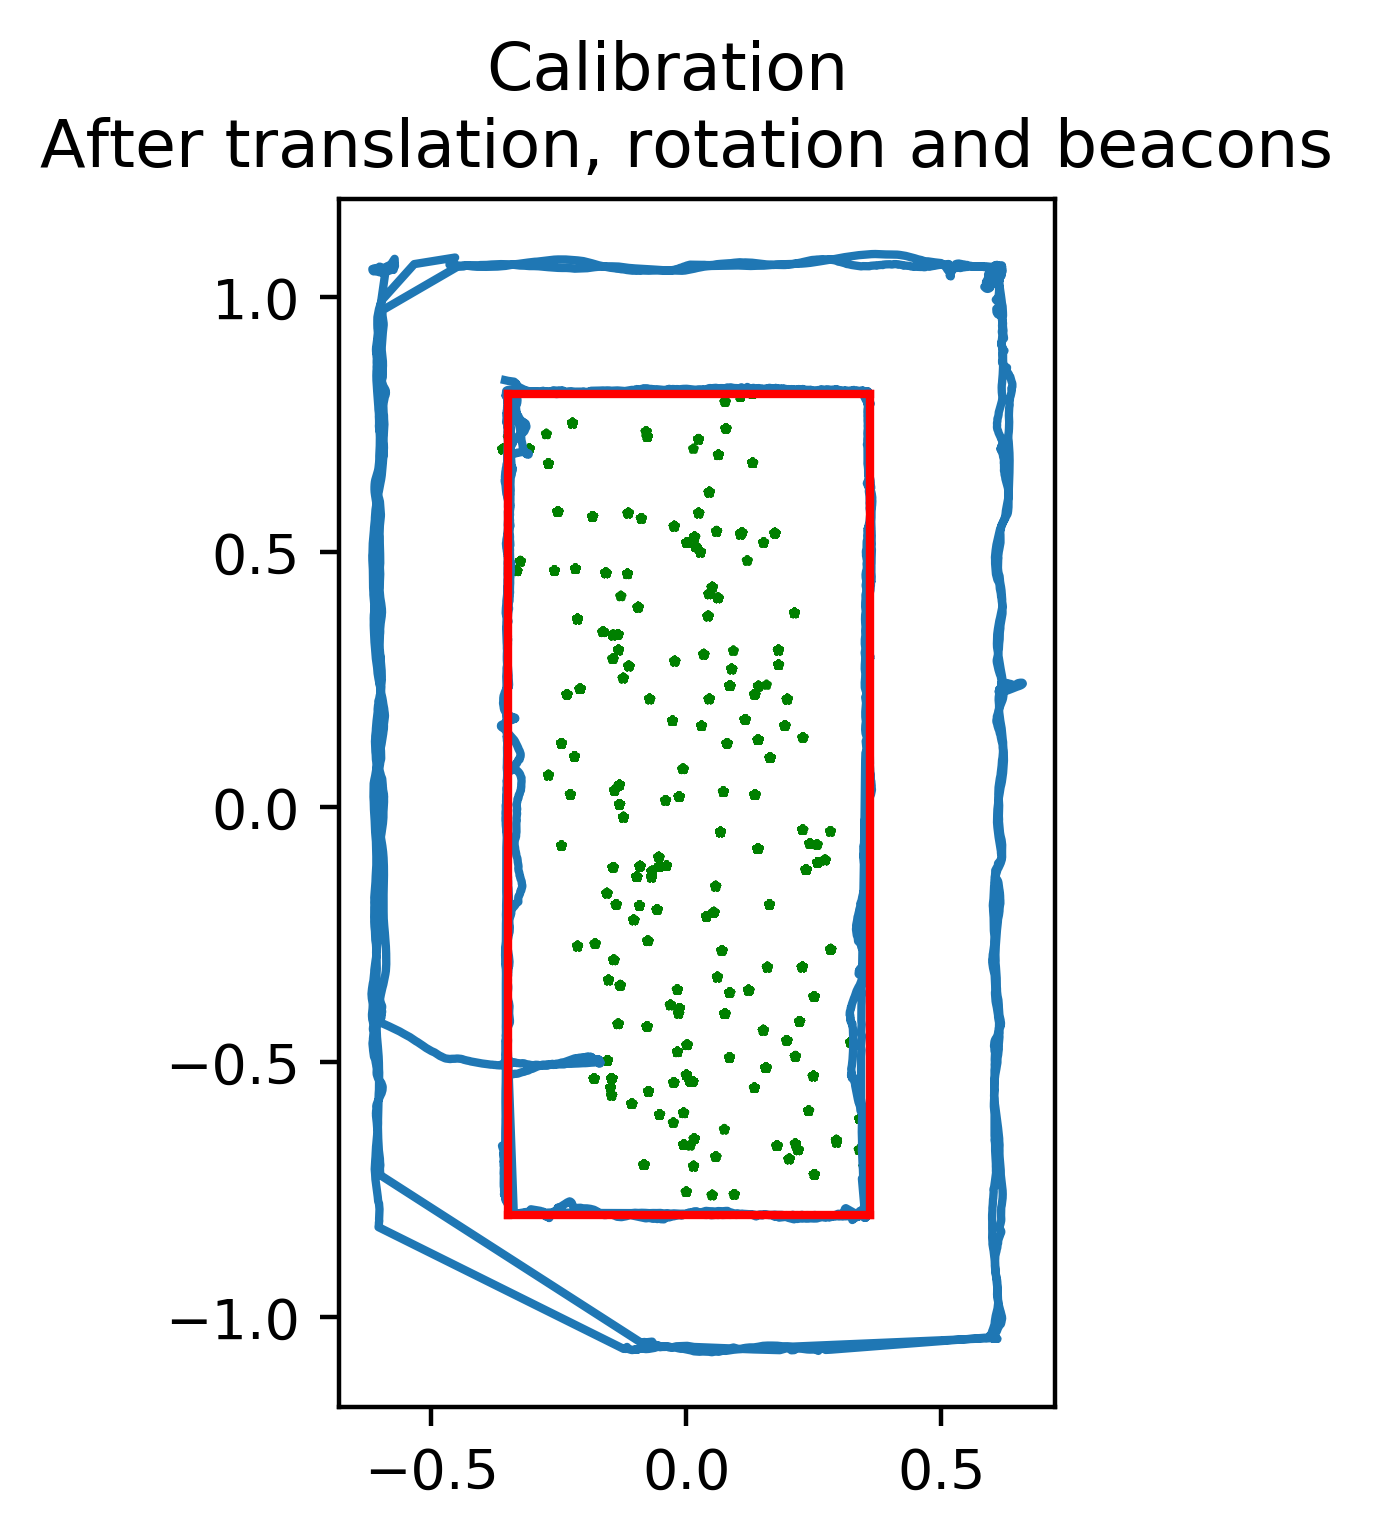

In [18]:
CALIB1 = pd.read_csv(root+'BPositions_CALIBRATION_20210610-111132/position_20210610-111132.txt',sep=" ", header=None)    
CALIB1[1]= CALIB1[1]-xcut_offset
CALIB1[3]= CALIB1[3]+ycut_offset
rot_position_data=  rotation_correction_points(CALIB1,alpha=rotation)
fig, ax1 = plt.subplots(1, 1, sharex=True,dpi=400, sharey=True)
fig.suptitle("Calibration")
ax1.set_title('After translation, rotation and beacons ')
rearing3 = pd.read_excel(processed +'FS03_rears.xlsx')
rearing3 = rotation_correction_beacons(rearing3,alpha=rotation)
ax1.plot(rot_position_data[1],rot_position_data[3])
ax1.plot([(X_cut_min+cut)-xcut_offset,(X_cut_max-cut)-xcut_offset],[(Y_cut_max-cut)+ycut_offset,(Y_cut_max-cut)+ycut_offset] ,'r-')
ax1.plot([(X_cut_min+cut)-xcut_offset,(X_cut_min+cut)-xcut_offset],[(Y_cut_min+cut)+ycut_offset,(Y_cut_max-cut)+ycut_offset] ,'r-')
ax1.plot([(X_cut_max-cut)-xcut_offset,(X_cut_max-cut)-xcut_offset],[(Y_cut_min+cut)+ycut_offset,(Y_cut_max-cut)+ycut_offset] ,'r-')
ax1.plot([(X_cut_max-cut)-xcut_offset,(X_cut_min+cut)-xcut_offset],[(Y_cut_min+cut)+ycut_offset,(Y_cut_min+cut)+ycut_offset] ,'r-')
ax1.scatter(rearing3["BeaconX"],rearing3["BeaconY"],s=1,marker='*', facecolors='none', edgecolors='green')
plt.gca().set_aspect('equal')

### A. get secific point per rear event in center of arena

In [19]:
def Z_period_points(positions):
    """get every rear event in center of arena
    
    If animal gets above .62 detect it as one until below again
    
    PARAMS
    ------------
    positions : DataFrame 
    
    Returns
    ------------
    Data Frame with all rears position (begining of rear) and time. 

    """
    high =0 
    low = 0
    switch = 0 
    last = .60
    high_points=[]
    z= positions[2]
    count = 0 
    for height in z: 
        if height >.62 and last<.62:
            high +=1  
            if  (X_cut_min+cut)< positions[1][count]<(X_cut_max-cut) and (Y_cut_min+cut)< positions[3][count]<(Y_cut_max-cut):
                high_points.append((positions[0][count],positions[1][count],positions[3][count],positions[2][count]))
        last = height
        count +=1
        
    return pd.DataFrame(high_points)
Z_points= Z_period_points(FS03_position)
Z_points.head()

,0,1,2,3
0,1615566506.380,-0.509,0.334,0.628
1,1615566510.780,-0.441,0.248,0.625
2,1615566529.700,-0.425,0.719,0.629
3,1615566534.740,-0.568,1.607,0.622
4,1615566547.110,-0.583,1.587,0.622


### B. Add 6th column to beacon file if visible or not

In [20]:
FS03_beacon = pd.read_csv(root3+'beacons_20210312-172823.txt',sep=" ", header=None)
FS03_beacon.head()

,0,1,2,3,4,5
0,1615566511.420,-0.403,0.693,0.304,-0.177,-0.524
1,1615566575.040,-0.477,0.689,0.286,-0.177,-0.524
2,1615566591.520,-0.486,0.660,0.339,-0.177,-0.524
3,1615566654.670,-0.436,0.699,0.326,-0.177,-0.524
4,1615566660.580,-0.432,0.723,0.291,-0.177,-0.524


In [21]:
def vis_invis(beacon,light_off=4):
    """ Add 6th column to beacon file if visible or not
        
    PARAMS
    ------------
    beacon : DataFrame
        beacons
    light_off : int 
        how often beacon visible 
    
    Returns
    ------------
    Data Frame with all beacon position and if visible or not

    """
    visibility=[]
    for i in beacon.index:
        if((i+1) % light_off == 0):
            visibility.append(0)
        else:
            visibility.append(1)
    beacon[6]=visibility
    return beacon
FS03_beacon=vis_invis(FS03_beacon) 
FS03_beacon.head()

,0,1,2,3,4,5,6
0,1615566511.420,-0.403,0.693,0.304,-0.177,-0.524,1
1,1615566575.040,-0.477,0.689,0.286,-0.177,-0.524,1
2,1615566591.520,-0.486,0.660,0.339,-0.177,-0.524,1
3,1615566654.670,-0.436,0.699,0.326,-0.177,-0.524,0
4,1615566660.580,-0.432,0.723,0.291,-0.177,-0.524,1


## B2. Make a dataframe of time when beacon invisible

### B. Find succesfull invisible trials and name them 2 in the 6th column

In [22]:
def invis_succ_meta(beacon,invisible_time=60,light_off=6):
    """Find succesfull invisible trials and name them 2 in the 6th column also incorporate metadata to subtract correctly        
    PARAMS
    ------------
    beacon : DataFrame
        beacons
    invisible_time ; int 
        Inter trial interval time
    light_off : int 
        how often beacon visible 
    
    Returns
    ------------
    Data Frame with all beacon position and if visible or not and collecting succesful visible trials 
    """
    invis=[]
    df = beacon[0].diff().to_frame()
    for ind in df.index:
        if df[0][ind]<invisible_time and ((ind+1) % light_off == 0):   
            invis.append(df[0][ind])
            beacon[6][ind]=2
    return beacon
FS03_beacon = invis_succ_meta(FS03_beacon,light_off=4)
FS03_beacon.head(5)


D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,0,1,2,3,4,5,6
0,1615566511.420,-0.403,0.693,0.304,-0.177,-0.524,1
1,1615566575.040,-0.477,0.689,0.286,-0.177,-0.524,1
2,1615566591.520,-0.486,0.660,0.339,-0.177,-0.524,1
3,1615566654.670,-0.436,0.699,0.326,-0.177,-0.524,0
4,1615566660.580,-0.432,0.723,0.291,-0.177,-0.524,1


### Make a list of time boundaries when beacon is invisible so we can put all rearign in there and mark it also add 2 when invisible beacon reached. 

In [23]:
# NEED TO FIX THIS to give only times when invisible is true 

def invis_times_meta(beacon,invisible_time=60,light_off=4):
    """Add invisible time from beacon       
    PARAMS
    ------------
    beacon : DataFrame
        beacons
    invisible_time ; int 
        Inter trial interval time
    light_off : int 
        how often beacon visible 
    
    Returns
    ------------
    Data Frame with all beacon position and if visible or not and collecting 
    succesful visible trials an dho much time elapsed since invisible beacon

    """
    invis=[]
    beacon[7]=0.0
    df = beacon[0].diff().to_frame()
    for ind in df.index:
        if df[0][ind]>invisible_time and ((ind+1) % light_off == 0):
            beacon[7][ind]= beacon[0][ind-1]+invisible_time
            invis.append((beacon[0][ind-1],beacon[0][ind-1]+invisible_time))
        elif ((ind+1) % light_off == 0):
            invis.append((beacon[0][ind-1],beacon[0][ind]))
            beacon[7][ind] = beacon[0][ind]
        else: 
            beacon[7][ind] = beacon[0][ind]
    return beacon,invis
FS03_beacon,times = invis_times_meta(FS03_beacon)
FS03_beacon.head(20)

D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,0,1,2,3,4,5,6,7
0,1615566511.420,-0.403,0.693,0.304,-0.177,-0.524,1,1615566511.420
1,1615566575.040,-0.477,0.689,0.286,-0.177,-0.524,1,1615566575.040
2,1615566591.520,-0.486,0.660,0.339,-0.177,-0.524,1,1615566591.520
3,1615566654.670,-0.436,0.699,0.326,-0.177,-0.524,0,1615566651.520
4,1615566660.580,-0.432,0.723,0.291,-0.177,-0.524,1,1615566660.580
5,1615566694.100,-0.451,0.713,0.367,-0.177,-0.524,1,1615566694.100
6,1615566699.110,-0.424,0.694,0.267,-0.177,-0.524,1,1615566699.110
7,1615566761.100,-0.441,0.697,0.272,-0.177,-0.524,0,1615566759.110
8,1615566770.400,-0.480,0.689,0.324,-0.177,-0.524,1,1615566770.400
9,1615566833.340,-0.449,0.693,0.280,-0.177,-0.524,1,1615566833.340


In [24]:
times

[(1615566591.52, 1615566651.52),
 (1615566699.11, 1615566759.11),
 (1615566855.78, 1615566894.46),
 (1615566981.11, 1615567041.11),
 (1615567130.89, 1615567190.89),
 (1615567286.87, 1615567346.87),
 (1615567430.68, 1615567446.89),
 (1615567549.14, 1615567609.14),
 (1615567686.43, 1615567746.43),
 (1615567882.7, 1615567942.7),
 (1615568022.02, 1615568082.02),
 (1615568204.07, 1615568260.29)]

### Create data frame with matching to append invisibility or not and substarct position from rears so it is centralized.

### C. Match and connect rearing file with beacon file - add a beacon location and visibility column, also correct for position to centralize. Need to also add when previous beacon changed because not all beacons are triggered by rears - then it can be bug. So Add an extra column that has the time from beacon 

In [25]:
def match_and_append(Z_points,beacon,times):
    """Matchs a beacon to a particular rear and join into one data frame also rotate them! 
    PARAMS
    ------------
    Z_points : DataFrame
        rears
    beacon ; DataFrame 
        beacon
    times : tuples
        tuple of all invisible intervals  
    
    Returns
    ------------
    Data Frame with all beacon position matching to rears 

    """
    alpha= 1.7
    df_rears = Z_points
    df_rears[7]=1
    df_rears[8]=0
    i=0
    Xs=[]
    Ys=[]
    visibility=[]
    beacon_trigger=[]
    beacon_seen_in_rear=[]
    for index, row in df_rears.iterrows():
        k = beacon.iloc[(beacon[0] - row[0]).abs().argsort()[:1]]
        for r in times:
            if r[0]<row[0]<r[1]:
                df_rears.loc[index,7]=0
            elif df_rears.loc[index,7]==0:
                break
        if row[0] <= beacon[0][i]:   
            beacon_trigger.append(beacon[0][i])
            Xs.append(beacon[4][i])
            Ys.append(beacon[5][i])
            #visibility.append(beacon[6][i])
        elif row[0] > beacon[0][i] and i<len(beacon)-1:
            #print(len(beacon))
            i+=1
            beacon_trigger.append(beacon[0][i])
            Xs.append(beacon[4][i])
            Ys.append(beacon[5][i])
            #visibility.append(beacon[6][i])
        else:
            beacon_trigger.append(beacon[0][i])
            Xs.append(beacon[4][i])
            Ys.append(beacon[5][i])
            #visibility.append(beacon[6][i])
            
    df_rears[8]=beacon_trigger
    #return rearing

    #print(beacon_seen_in_rear)
    df_rears[4]=Xs
    df_rears[5]=Ys
    #df_rears[6]=visibility
    df_rears[8]=beacon_trigger
    #df_rears[8]=beacon_seen_in_rear
    df_rears_corrected=df_rears
    df_rears_corrected[1]=df_rears[1]-x_offset
    df_rears_corrected[2]=df_rears[2]-y_offset 
    
    #Rotate beacons 
    alpha = (alpha) * np.pi / 180
    Xs= df_rears_corrected[4]
    Ys= df_rears_corrected[5]
    df_rears[4] = Xs * np.cos(alpha) - Ys * np.sin(alpha)
    df_rears[5] = Xs * np.sin(alpha) + Ys * np.cos(alpha)
    #Rotate positions
    Xpos= df_rears_corrected[1]
    Ypos= df_rears_corrected[2]
    df_rears_corrected[1]= Xpos * np.cos(alpha) - Ypos * np.sin(alpha)
    df_rears_corrected[2]= Xpos * np.sin(alpha) + Ypos * np.cos(alpha)
    
    return df_rears_corrected[[0,1,2,3,4,5,7,8]]
rearing = match_and_append(Z_points,FS03_beacon,times)
print(rearing.size)
rearing.head()


1136


,0,1,2,3,4,5,7,8
0,1615566506.380,-0.260,-0.478,0.628,-0.162,-0.529,1,1615566511.420
1,1615566510.780,-0.189,-0.563,0.625,-0.162,-0.529,1,1615566511.420
2,1615566529.700,-0.188,-0.092,0.629,-0.162,-0.529,1,1615566575.040
3,1615566534.740,-0.357,0.791,0.622,-0.162,-0.529,1,1615566575.040
4,1615566547.110,-0.371,0.771,0.622,-0.162,-0.529,1,1615566575.040


### Detect change in beacon location - assign beacon group number and subnumber 

In [26]:
def beacon_group(rearing,location_change=10 ):
    """   
    Detect change in beacon location - create beacon group number for fatigue measures
    
    PARAMS
    ------------
    rears : DataFrame
        rearing    
    location_change : int 
        from metadata
        
    Returns
    ------------
    Data Frame with named by group and how many beacons already

    """
    group = []
    sub_group = []
    group_num=0
    sub_group_num=0
    rearing[9] = rearing[4].shift() != rearing[4]
    rearing[10] = rearing[8].shift() != rearing[8]
    rearing[11]= rearing[8].shift() != rearing[8]
    for index,row in rearing.iterrows():
        if row[9] == True:
            group_num +=1
            group.append(group_num)
        else: 
            group.append(group_num)
    for index,row in rearing.iterrows():
        if row[10] == True and sub_group_num<location_change:
            sub_group_num +=1
            sub_group.append(sub_group_num)

        elif row[10] == True and sub_group_num==location_change:
            sub_group_num =1
            sub_group.append(sub_group_num)
        else: 
            sub_group.append(sub_group_num)         
    rearing[9]=group
    rearing[10]=sub_group
    return rearing
beacon_group(rearing)
rearing

D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

,0,1,2,3,4,5,7,8,9,10,11
0,1615566506.380,-0.260,-0.478,0.628,-0.162,-0.529,1,1615566511.420,1,1,True
1,1615566510.780,-0.189,-0.563,0.625,-0.162,-0.529,1,1615566511.420,1,1,False
2,1615566529.700,-0.188,-0.092,0.629,-0.162,-0.529,1,1615566575.040,1,2,True
3,1615566534.740,-0.357,0.791,0.622,-0.162,-0.529,1,1615566575.040,1,2,False
4,1615566547.110,-0.371,0.771,0.622,-0.162,-0.529,1,1615566575.040,1,2,False
5,1615566562.340,-0.311,-0.795,0.640,-0.162,-0.529,1,1615566575.040,1,2,False
6,1615566568.820,0.319,-0.747,0.622,-0.162,-0.529,1,1615566575.040,1,2,False
7,1615566572.920,-0.254,-0.420,0.625,-0.162,-0.529,1,1615566575.040,1,2,False
8,1615566574.530,-0.236,-0.541,0.622,-0.162,-0.529,1,1615566575.040,1,2,False
9,1615566591.010,-0.239,-0.471,0.620,-0.162,-0.529,1,1615566591.520,1,3,True


### E. Now all in one cell

### Run it in a loop to make one data frame 

In [27]:
def make_rearing_df_meta(position,beacon,invisible_time=60,light_off=2,location_change=10):
    """   
    Run all and merge 
    
    PARAMS
    ------------
    position: Data Frame 
        positions
    beacon : DataFrame 
        beacon
    invisible_time : int
        Inter trial interval 
    light_off :int 
        starting invisibility       
    location_change : int 
        from metadata when beacon changes location
        
    Returns
    ------------
    Data Frame - complete with rears time and beacon groups 

    """
    Z_points= Z_period_points(position)
    beacon=vis_invis(beacon,light_off=2)
    beacon=invis_succ_meta(beacon,invisible_time=60,light_off=2)
    beacon,times = invis_times_meta(beacon,invisible_time=60,light_off=2)
    rearing_df=match_and_append(Z_points,beacon,times)
    rearing_df=beacon_group(rearing_df,location_change=10)
    return rearing_df

In [28]:
#Tester 
ii=make_rearing_df_meta(FS03_position,FS03_beacon,invisible_time=60,light_off=2)
jj=make_rearing_df_meta(FS03_position,FS03_beacon,invisible_time=60,light_off=2)
bb= ii.append(jj,ignore_index=True)
#kk=pd.concat([pp,rr],ignore_index=True)
len(bb.index)

D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

284

20211006-145401
Match found making rearing file


D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

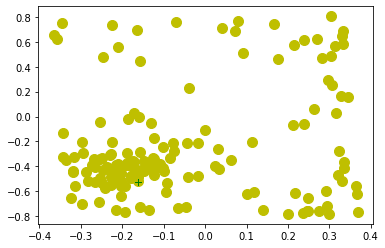

20211007-155054
Match found making rearing file


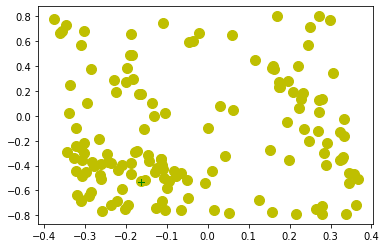

20211011-090846
Match found making rearing file


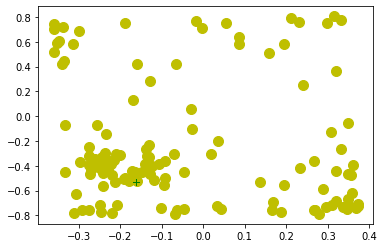

20211014-152539
Match found making rearing file


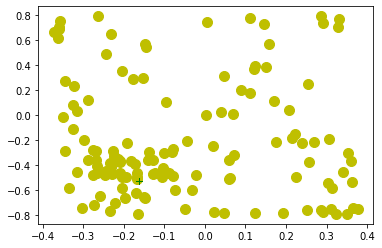

20211015-164632
Match found making rearing file


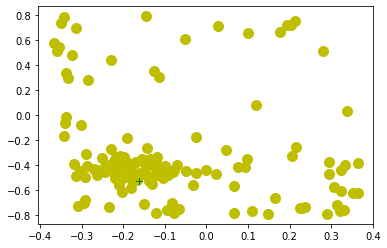

20211019-162543
Match found making rearing file


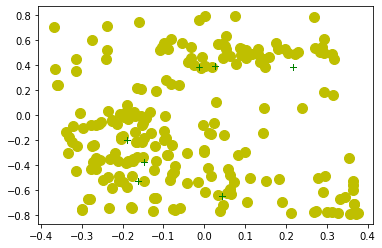

20211022-131040
Match found making rearing file


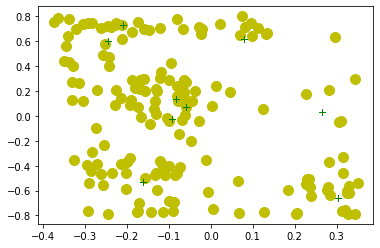

20211023-183301
Match found making rearing file


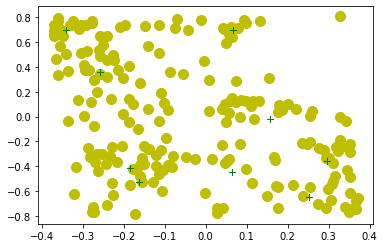

20211025-135419
Match found making rearing file


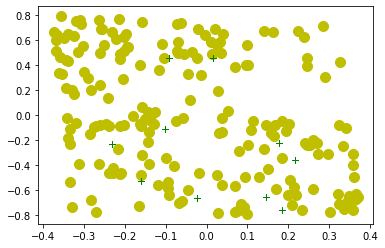

20211026-164331
Match found making rearing file


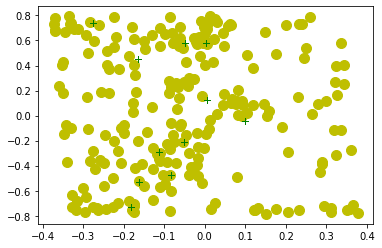

20211027-200900
Match found making rearing file


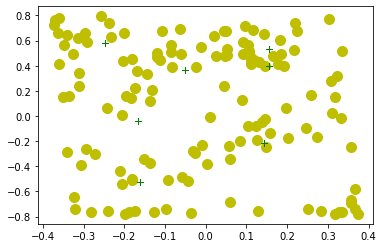

20211029-172916
Match found making rearing file


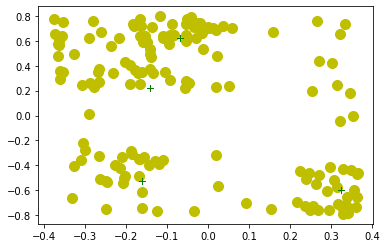

20211101-191934
Match found making rearing file


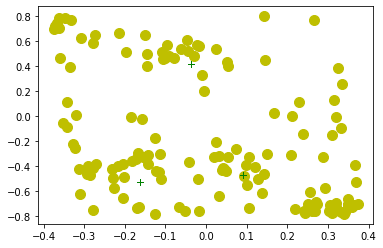

20211102-151034
Match found making rearing file


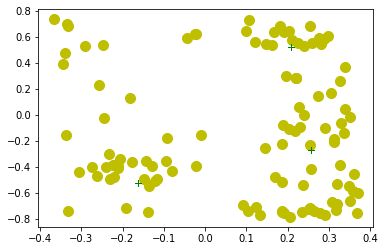

20211103-144559
Match found making rearing file


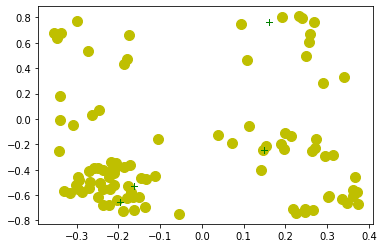

20211104-151720
Match found making rearing file


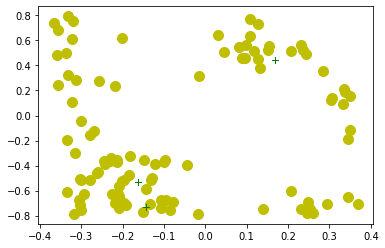

20211108-154456
Match found making rearing file


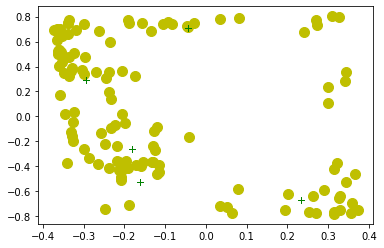

20211109-134609
Match found making rearing file


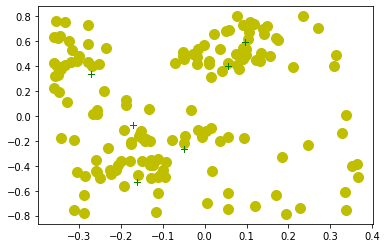

20211110-144941
Match found making rearing file


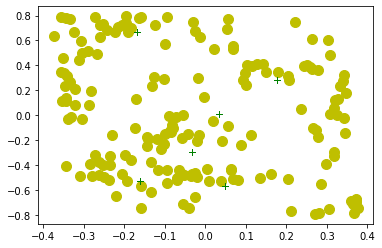

20211111-164730
Match found making rearing file


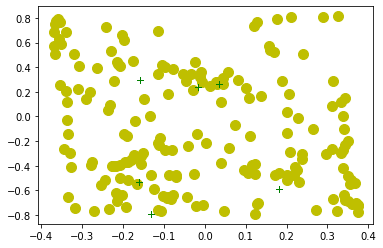

20211114-182416
Match found making rearing file


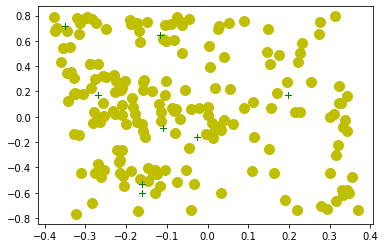

20211115-164349
Match found making rearing file


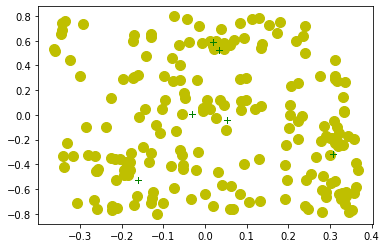

20211116-160113
Match found making rearing file


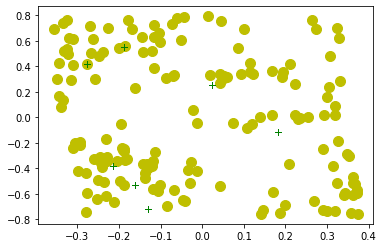

20211117-203000
Match found making rearing file


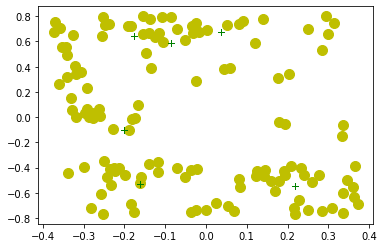

20211118-182248
Match found making rearing file


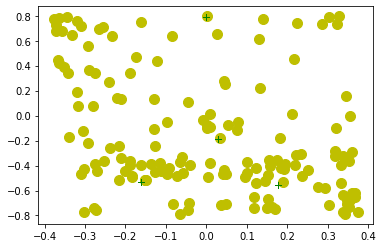

20211120-183947
Match found making rearing file


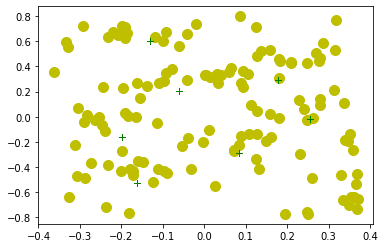

20211123-185323
Match found making rearing file


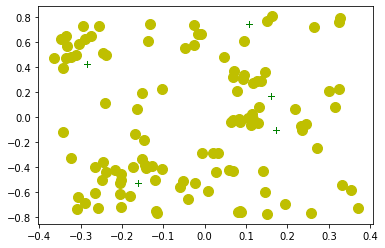

20211124-215755
Match found making rearing file


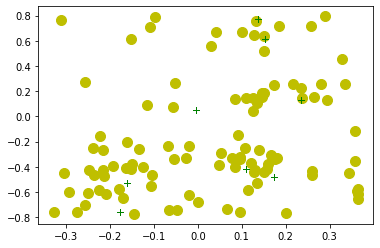

20211126-104417
Match found making rearing file


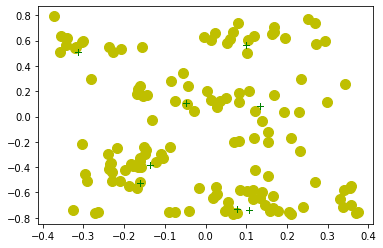

20211129-131454
Match found making rearing file


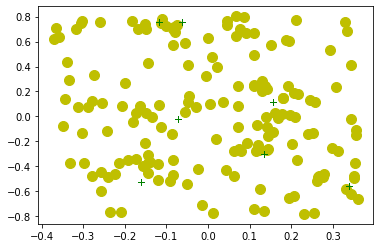

DataFrame made.


NameError: name 'how_many' is not defined

In [29]:
import os 
from datetime import datetime
import time

def crawl_make_and_safe (rat_ID,Save_plots=True ):
    """   
    Crawl through, find metadata, beacons and position files that match and run all the function above to then save a spread sheet. 
    
    PARAMS
    ------------
    Rat_ID: str 
        name of animal ['FS09']
    Save plots: boolean
        To save session rearign plots or not       
        
    Returns
    ------------
    nothing - automatically saves into processed 

    """

    Save_plots=True  #Do you want to?????
    how_many= 0 
    substring = "BPositions_"
    position = "position_2"
    beacon = 'beacons'
    metadata = 'metadata'
    animal= '//10.153.170.3/storage2/fabian/data/project/'+rat_ID  
    average_rears=[]
    animal_dir = os.path.join(figures+rat_ID)
    if not os.path.isdir(animal_dir):
        os.makedirs(animal_dir)
    rearing = pd.DataFrame()
    all_metadata=pd.DataFrame()
    for dirpath, dirnames, files in os.walk(animal, topdown=True):
        fullstring = dirpath
        for file_name in files:
            fullstring = dirpath
            if beacon in file_name:
                beacons  = pd.read_csv(dirpath+'/'+file_name,sep=" ", header = None,engine='python')
                beacon_date = list(file_name)
            if metadata in file_name:
                metadatas  = pd.read_csv(dirpath+'/'+file_name,sep=" : ", header = None,engine='python')
                df=metadatas.T 
                df= df.rename(columns=df.iloc[0])
                df=df.drop(df.index[0])
                if int(df['Pellets'].values[0])>1:
                    all_metadata = all_metadata.append(df, ignore_index=True,sort=False)
                    invisible_time=int(df['invisible_time'].values[0])
                    light_off=int(df['light_off'].values[0])
                    location_change = (df['position_change'].values[0])
                    Computer_time_was = (df['Computer time was'].values[0])
                    #print(int(Computer_time_was))
                    time_stamp = datetime.fromtimestamp(int(float(Computer_time_was))).strftime('%Y%m%d-%H%M%S')
                    print(time_stamp)
            if position in file_name:
                positions = pd.read_csv(dirpath+'/'+file_name,sep=" ", header=None,engine='python')
                positions_date= list(file_name)
                if beacon_date[-9:]==positions_date[-9:]:
                    print ("Match found making rearing file")
                    how_many += 1
                    rearing_df=make_rearing_df_meta(positions,beacons,invisible_time=invisible_time,light_off=light_off,location_change=location_change)
                    average_rears.append(len(rearing_df.index))
                    plt.plot(rearing_df[1],rearing_df[2],'yo',ms=10)
                    plt.plot(rearing_df[4],rearing_df[5],'g+')  
                    if Save_plots==True:
                        plt.savefig('%s/%srears_%s.png'%(animal_dir,time_stamp,rat_ID), dpi = 200)
                    plt.show()
                    if how_many<1.5:
                        rearing = rearing_df
                        #print(rearing)
                    else:
                        rearing = rearing.append(rearing_df,ignore_index=True)                    
                else: 
                    print('bad match')
    sorted_data = all_metadata.sort_values('Computer time was',)

    #SAVER AND NAMING  FUNCTIONS 
    writer = pd.ExcelWriter(processed + rat_ID+'_metadata.xlsx')
    sorted_data.to_excel(writer)
    writer.save()

    rearing.columns=["Time", "RatX","RatY", "RatZ","BeaconX", "BeaconY","Visibility","time_of_beacon_trigger","Beacon_group",'Beacon_subgroup','trial_in_next', ]
    writer = pd.ExcelWriter(processed + rat_ID+'_rears_new.xlsx')
    rearing.to_excel(writer)
    writer.save()
    
crawl_make_and_safe(rat_ID='FS09',Save_plots=False)
    
    
print('DataFrame made.')           
print ('Matched %s files' %(how_many))

In [ ]:
crawl_make_and_safe(rat_ID='FS10',Save_plots=True)
crawl_make_and_safe(rat_ID='FS11',Save_plots=True)
crawl_make_and_safe(rat_ID='FS08',Save_plots=True)

In [274]:
sorted_data.head()

,Recording started on,Computer time was,ITI_time,time_in_cylinder,movement_collection_time,animal_ID,background_color,circle,position_change,light_off,...,high pellets,high_time_in_cylinder,invisible_time,invisible_count,invisible_list,Animal jumped,Recording_started_motive,Recording_timestamp_motive,Day,invisible circle
0,2021-10-06 14:12:50,1633522370.51,1.5,1.5,0.01,FS08,000,0.075,1000,200,...,4,0.5,60,0,[],0,0,0.0,156,NaN
1,2021-10-07 16:25:16,1633616716.88,1.5,1.5,0.01,FS08,000,0.075,2000,2000,...,6,0.5,60,0,[],0,0,0.0,156,0.15
2,2021-10-11 08:31:49,1633933909.15,1.5,1.5,0.01,FS08,000,0.075,2000,2000,...,5,0.5,60,0,[],0,0,0.0,156,0.15
3,2021-10-14 14:39:48,1634215188.78,1.5,1.5,0.01,FS08,000,0.075,2000,2000,...,12,0.5,60,0,[],0,0,0.0,156,0.15
4,2021-10-15 17:22:53,1634311373.92,1.5,1.5,0.01,FS08,000,0.075,10000,2000,...,10,0.5,60,0,[],0,0,0.0,156,0.15


In [269]:
rearing.head()

,0,1,2,3,4,5,7,8,9,10,11
0,1633522416.780,0.301,-0.713,0.622,-0.162,-0.529,1,1633522554.220,1,1,True
1,1633522417.630,0.261,-0.786,0.621,-0.162,-0.529,1,1633522554.220,1,1,False
2,1633522437.930,0.374,-0.709,0.628,-0.162,-0.529,1,1633522554.220,1,1,False
3,1633522439.700,0.280,-0.759,0.624,-0.162,-0.529,1,1633522554.220,1,1,False
4,1633522456.890,-0.358,0.772,0.621,-0.162,-0.529,1,1633522554.220,1,1,False


### E. Name all columns  and save file. 

### Do an all encompassing HDF5 export (metadata and rears)  - maybe not worth it since files are so small. not even a MB  - DOES NOT WORK _ NOT WORHT IT>>> 

In [278]:
h5File = (processed +'FS11_progress.h5')
rearing.to_hdf(h5File, key ="rears", mode='w',table=True)
sorted_data.to_hdf(h5File, key ="metadata", mode='w',table=True)


D:\Software\anaconda\lib\site-packages\pandas\core\generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['Recording started on', 'Computer time was', 'ITI_time', 'time_in_cylinder', 'movement_collection_time', 'animal_ID', 'background_color', 'circle', 'position_change', 'light_off', 'Cylinder_color', 'rotation', 'Pellets', 'Beacon', 'Sham', 'Distance', 'Speed', 'recording lenght', 'high pellets', 'high_time_in_cylinder', 'invisible_time', 'invisible_count', 'invisible_list', 'Animal jumped', 'Recording_started_motive', 'Recording_timestamp_motive', 'Day', 'invisible circle']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


# END OF PROCESSING 


### Create histogram of how far away from beacon when reared for all first  need to subtract differetn beacon location each time 

### BEACON ANALYSIS 

#### First calculate distance

In [21]:
def calculate_Distance(x,y): 
        """Calculates distance given position"""
        travel=0
        for i in range(len(y)-1):
            dist = math.sqrt((x[0+i] - x[1+i])**2 + (y[0+i] - y[1+i])**2)
            travel+=dist

        return travel 

### Simple rearing analysis graph

In [ ]:
rat_ID= 'FS08'
import statistics
fig, ax = plt.subplots(1,1,dpi=200,sharex=False)
ax.hist(average_rears,color="green", label='median=%s' %(statistics.median(average_rears)))
ax.set_title('Rears per session '+rat_ID)
ax.axvline(statistics.median(average_rears), color='k', linestyle='dashed', linewidth=1)
ax.set_ylabel('Frequency')
ax.legend()
plt.savefig('%srears_per_session_%s.png'%(figures,rat_ID), dpi = 100)

### Histogram of distance from beacon for all rears

(array([483., 415., 218., 194., 125.,  76.,  45.,  64.,  25.,   9.]),
 array([0.0079216 , 0.16996621, 0.33201082, 0.49405544, 0.65610005,
        0.81814466, 0.98018928, 1.14223389, 1.3042785 , 1.46632311,
        1.62836773]),
 <a list of 10 Patch objects>)

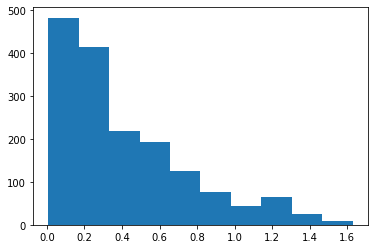

In [22]:
def get_rear_distance_from_beacon(df_rears_corrected):
    dist=[]
    for row in df_rears_corrected.iterrows():
        #print(row[1][1])
        #print(row[1][4])
        #print(row[1][2])
        #print(row[1][5])
        dist.append(math.sqrt((row[1][1] - row[1][4])**2 + (row[1][2] - row[1][5])**2))

    return dist 
plt.hist(get_rear_distance_from_beacon(rearing))

## Only for invisible succesfull

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

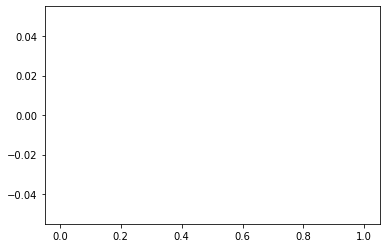

In [23]:
plt.hist(get_rear_distance_from_beacon(rearing.loc[rearing['Visibility']==3]))

## For visible succesful

(array([364., 337., 177., 163., 111.,  62.,  31.,  55.,  23.,   5.]),
 array([0.0079216 , 0.16996621, 0.33201082, 0.49405544, 0.65610005,
        0.81814466, 0.98018928, 1.14223389, 1.3042785 , 1.46632311,
        1.62836773]),
 <a list of 10 Patch objects>)

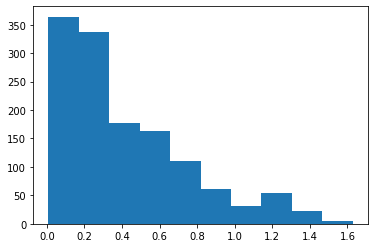

In [24]:
plt.hist(get_rear_distance_from_beacon(rearing.loc[rearing['Visibility']==1]))

### For visible only 

(array([118.,  78.,  41.,  31.,  11.,  18.,  12.,  10.,   2.,   5.]),
 array([0.00950373, 0.16822434, 0.32694495, 0.48566556, 0.64438617,
        0.80310678, 0.96182739, 1.120548  , 1.27926861, 1.43798922,
        1.59670983]),
 <a list of 10 Patch objects>)

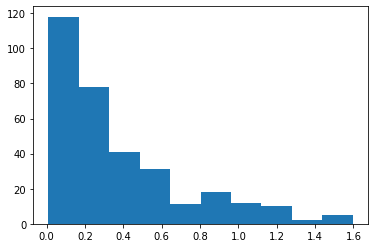

In [25]:
plt.hist(get_rear_distance_from_beacon(rearing.loc[rearing['Visibility']==0]))

### Invisible but succesfull

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

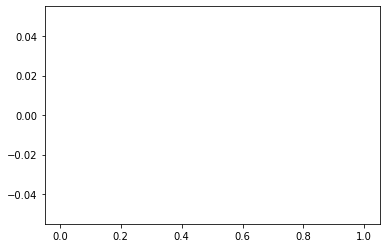

In [26]:
plt.hist(get_rear_distance_from_beacon(rearing.loc[rearing['Visibility']==2]))

In [51]:
processed= 'C:/Users/Fabian/Desktop/Analysis/Round3_FS03_FS06/processed/'
rearing_FS04 = pd.read_excel(processed + 'FS04_rears_new.xlsx',index_col=0)
rearing_FS03 = pd.read_excel(processed + 'FS03_rears_new.xlsx',index_col=0)
rearing_FS08 = pd.read_excel(processed + 'FS08_rears_new.xlsx',index_col=0)



In [345]:
rearing_FS08 = pd.read_excel(processed + 'FS08_rears_new.xlsx',index_col=0)
rearing_FS08.head()

,Time,RatX,RatY,RatZ,BeaconX,BeaconY,Visibility,time_of_beacon_trigger,Beacon_group,Beacon_subgroup,trial_in_next
0,1633522416.780,0.301,-0.713,0.622,-0.162,-0.529,1,1633522554.220,1,1,True
1,1633522417.630,0.261,-0.786,0.621,-0.162,-0.529,1,1633522554.220,1,1,False
2,1633522437.930,0.374,-0.709,0.628,-0.162,-0.529,1,1633522554.220,1,1,False
3,1633522439.700,0.280,-0.759,0.624,-0.162,-0.529,1,1633522554.220,1,1,False
4,1633522456.890,-0.358,0.772,0.621,-0.162,-0.529,1,1633522554.220,1,1,False


In [28]:
binwidth=.075
bins=np.arange(0, 1.5 + binwidth, binwidth)
bins[1]= 0.085
bins

array([0.   , 0.085, 0.15 , 0.225, 0.3  , 0.375, 0.45 , 0.525, 0.6  ,
       0.675, 0.75 , 0.825, 0.9  , 0.975, 1.05 , 1.125, 1.2  , 1.275,
       1.35 , 1.425, 1.5  ])

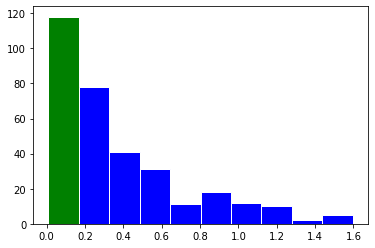

In [29]:
fig, ax = plt.subplots()
data = (get_rear_distance_from_beacon(rearing.loc[rearing['Visibility']==0]))

N, bins, patches = ax.hist(data, edgecolor='white', linewidth=1)

for i in range(0,1):
    patches[i].set_facecolor('g')
for i in range(1, len(patches)):
    patches[i].set_facecolor('blue')

plt.show()

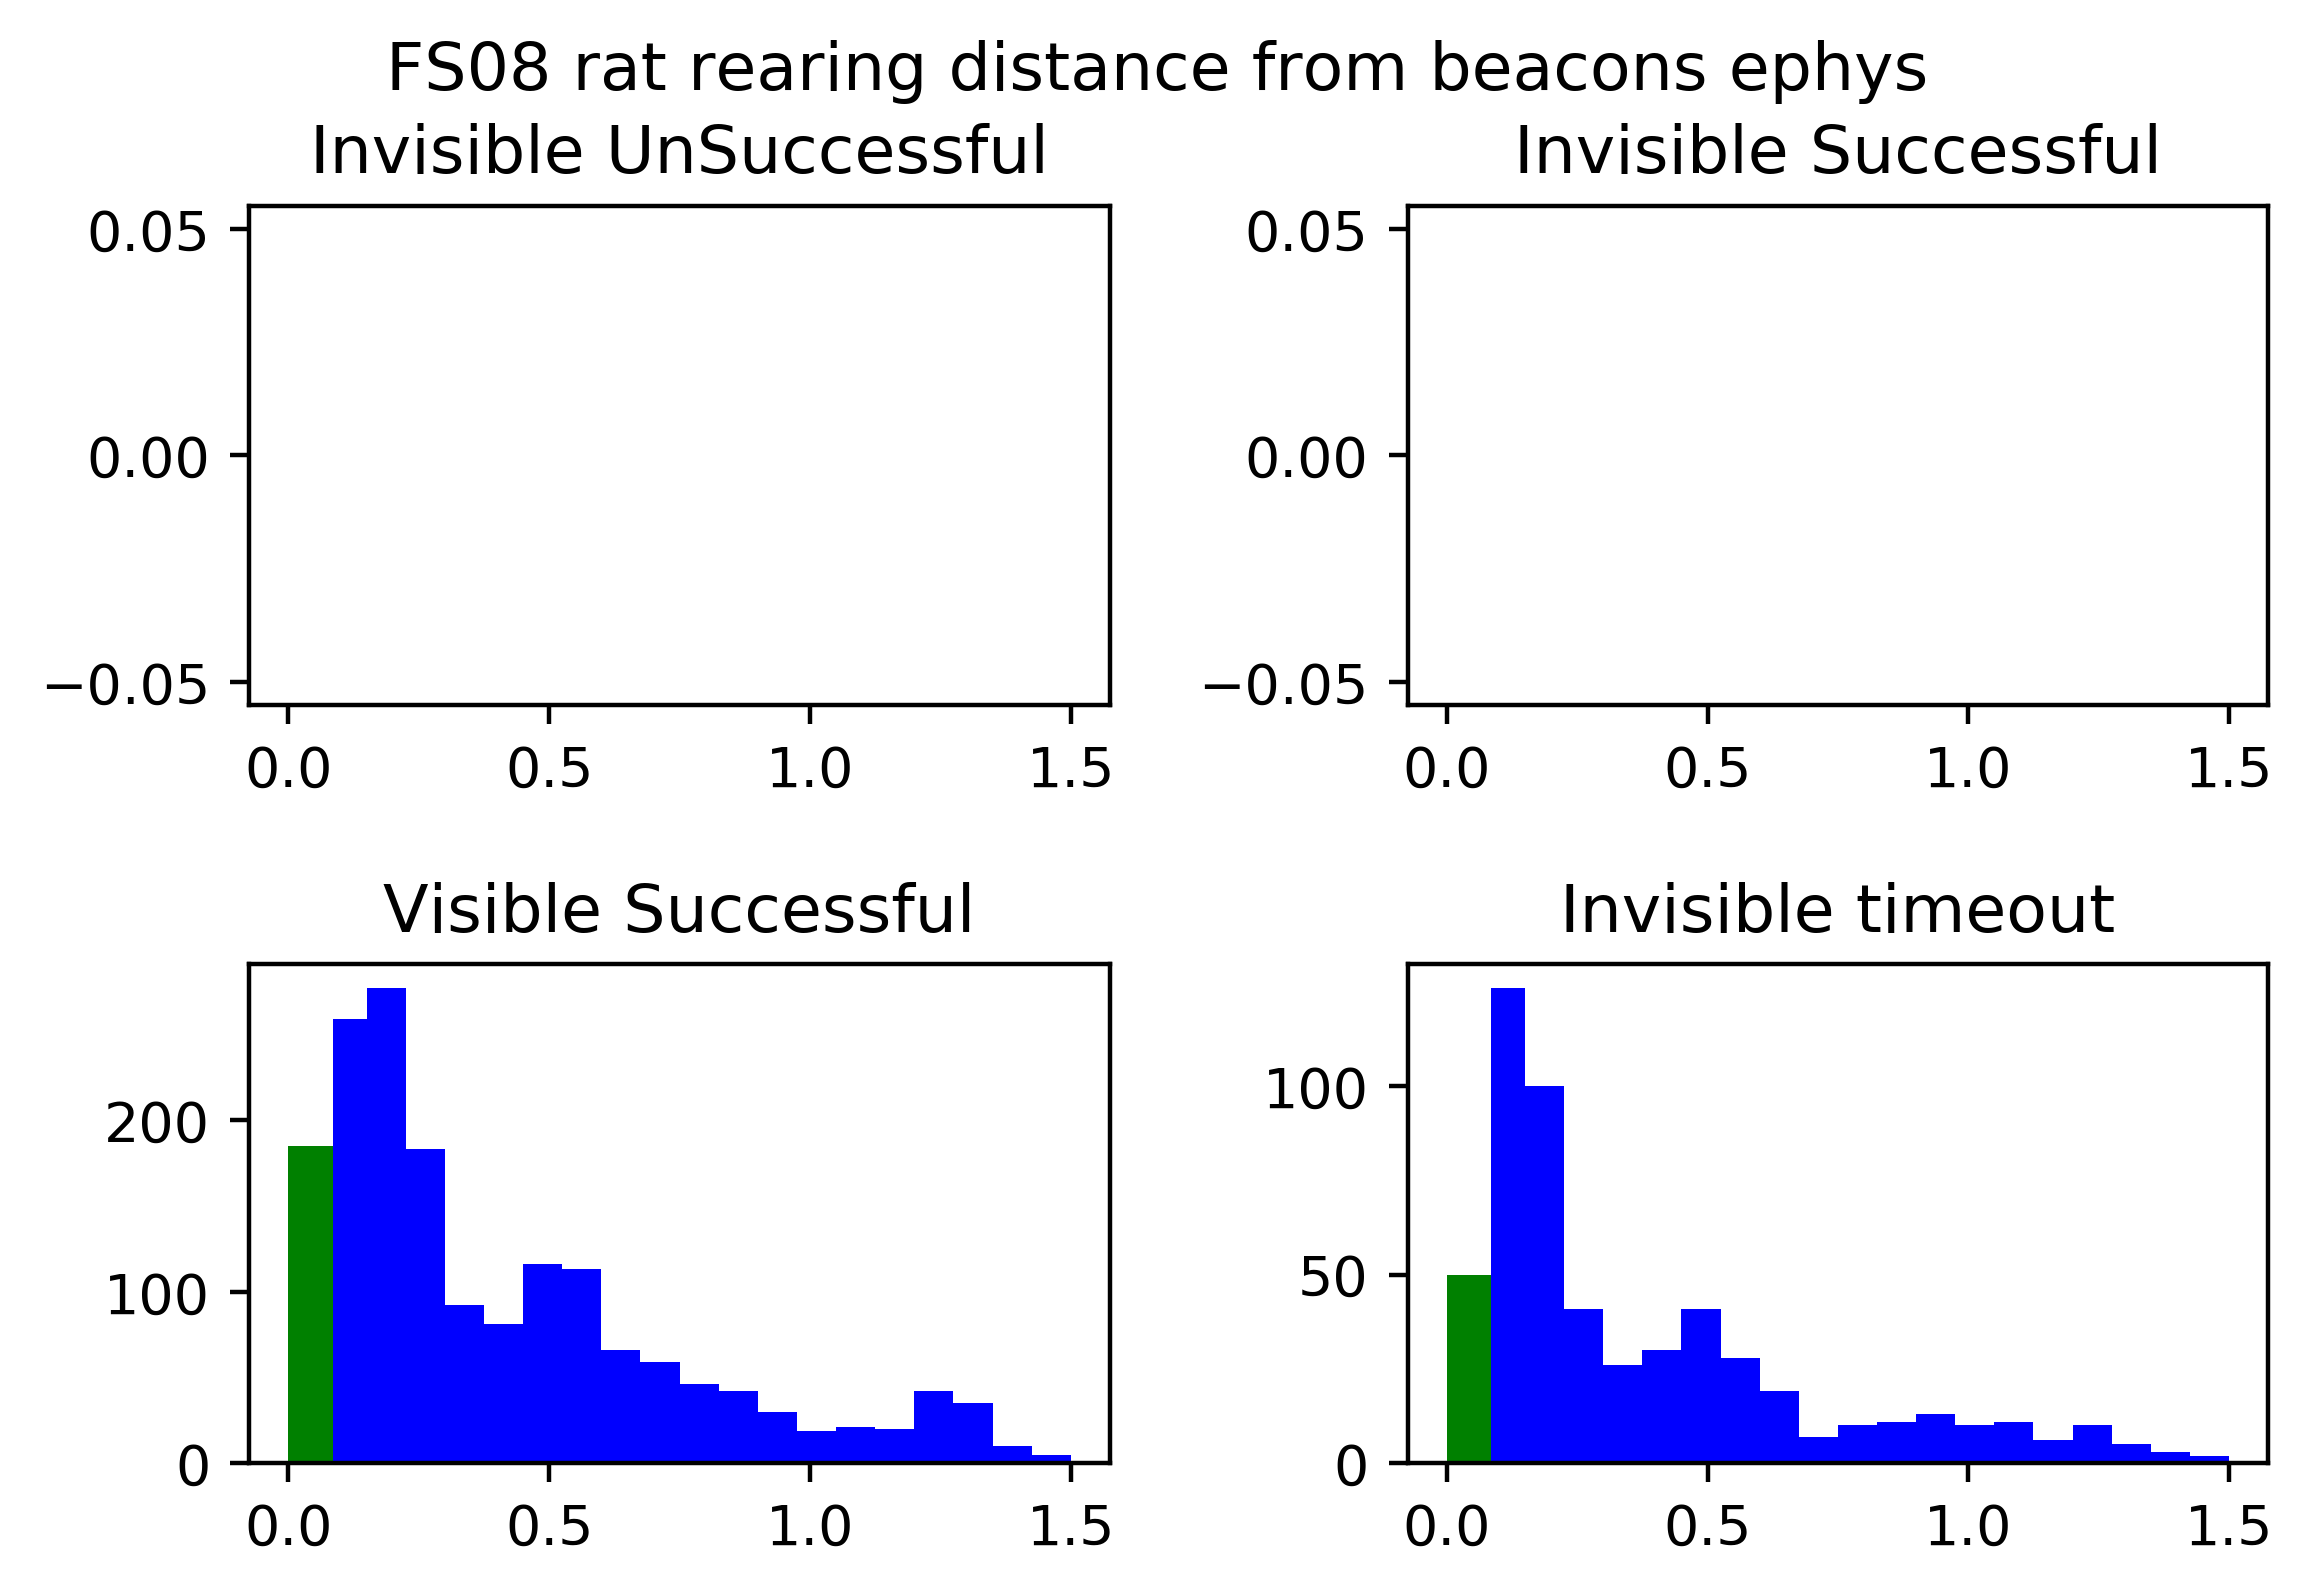

In [57]:
#rearing = 
def make_graphs (animal_ID,rearing):
    
    plt.tight_layout
    bins = np.arange(0, 1.5 + binwidth, binwidth)
    bins[1]= 0.085
    fig, ax = plt.subplots(2,2,dpi=400,sharex=False)
    fig.suptitle(animal_ID +' rat rearing distance from beacons ephys',y=1)
    #ax[0][0].bar(day_list_short,sorted_data['Pellets'],label='pellets',color ='g')
    #ax[0][0].bar(day_list_short,sorted_data['high pellets'],label='high pellets',color ='y')
#     ax[0][0].set_title('1 session')
#     ax[0][0].legend(loc='upper left',prop={'size': 5})
#     ax[0][0].plot(rr[1],rr[2],'bo',ms=2)
#     ax[0][0].plot([(X_cut_min+cut)-x_offset,(X_cut_max-cut)-x_offset],[(Y_cut_max-cut)+y_offset,(Y_cut_max-cut)+y_offset] ,'r-')
#     ax[0][0].plot([(X_cut_min+cut)-x_offset,(X_cut_min+cut)-x_offset],[(Y_cut_min+cut)+y_offset,(Y_cut_max-cut)+y_offset] ,'r-')
#     ax[0][0].plot([(X_cut_max-cut)-x_offset,(X_cut_max-cut)-x_offset],[(Y_cut_min+cut)+y_offset,(Y_cut_max-cut)+y_offset] ,'r-')
#     ax[0][0].plot([(X_cut_max-cut)-x_offset,(X_cut_min+cut)-x_offset],[(Y_cut_min+cut)+y_offset,(Y_cut_min+cut)+y_offset] ,'r-')
#     ax[0][0].scatter(rr[4],rr[5],s=220,marker='o', facecolors='none', edgecolors='green')
    #ax[1][1].set_xlabel('day')
    #ax[1][0].set_xlabel('day')
    #ax[0][0].set_ylabel('pellets')
    
    N, bins, patches=ax[0][0].hist(get_rear_distance_from_beacon(rearing.loc[rearing['Visibility']==3]),bins=bins)
#     ax[0][1].plot(day_list_short,sorted_data['Sham'],label = 'sham')
#     ax[0][1].legend(loc='upper left',prop={'size': 5})
    ax[0][0].set_title('Invisible UnSuccessful')
#     #ax[0][1].set_ylabel('time in beacon')
    for i in range(0,1):
        patches[i].set_facecolor('g')
    for i in range(1, len(patches)):
        patches[i].set_facecolor('blue')
        fig.tight_layout(pad=1.5)


    N, bins, patches=ax[0][1].hist(get_rear_distance_from_beacon(rearing.loc[rearing['Visibility']==2]),bins=bins)
#     ax[0][1].plot(day_list_short,sorted_data['Sham'],label = 'sham')
#     ax[0][1].legend(loc='upper left',prop={'size': 5})
    ax[0][1].set_title('Invisible Successful')
#     #ax[0][1].set_ylabel('time in beacon')
    for i in range(0,1):
        patches[i].set_facecolor('g')
    for i in range(1, len(patches)):
        patches[i].set_facecolor('blue')
        fig.tight_layout(pad=1.5)
    N, bins, patches=ax[1][0].hist(get_rear_distance_from_beacon(rearing.loc[rearing['Visibility']==1]),bins=bins)
#     ax[1][0].plot(day_list_short,sorted_data['Distance'], label = 'distance')
#     ax[1][0].legend(loc='upper left',prop={'size': 5})
    ax[1][0].set_title('Visible Successful')
#     ax[1][0].set_ylabel('meters')
#     ax[1][0].tick_params(axis="x", labelsize=6, labelrotation=-60, labelcolor="turquoise")

    for i in range(0,1):
        patches[i].set_facecolor('g')
    for i in range(1, len(patches)):
        patches[i].set_facecolor('blue')
        fig.tight_layout(pad=1.5)
    

    N, bins, patches = ax[1][1].hist(get_rear_distance_from_beacon(rearing.loc[rearing['Visibility']==0]),bins=bins)
#     ax[1][1].plot(day_list_short,sorted_data['Speed'],label= 'speed',color = 'cyan')
#     ax[1][1].legend(loc='upper left',prop={'size': 5})
    ax[1][1].set_title('Invisible timeout')
#     ax[1][1].tick_params(axis="x", labelsize=6, labelrotation=-60, labelcolor="turquoise")
    
    for i in range(0,1):
        patches[i].set_facecolor('g')
    for i in range(1, len(patches)):
        patches[i].set_facecolor("blue")
        fig.tight_layout(pad=1.5)
    
    #plt.show()
    plt.savefig('%sPOST_Calib_rat_rearing_distance_from_beacons_hist_only%s.png'%(figures,animal_ID), dpi = 100)

    
make_graphs('FS08' ,rearing_FS08)    

### To simplify show attempts when beacon visible and rears when beacon invisible. This of course includes the time when the animla goes out to search for a pellet even if beacon visible.  

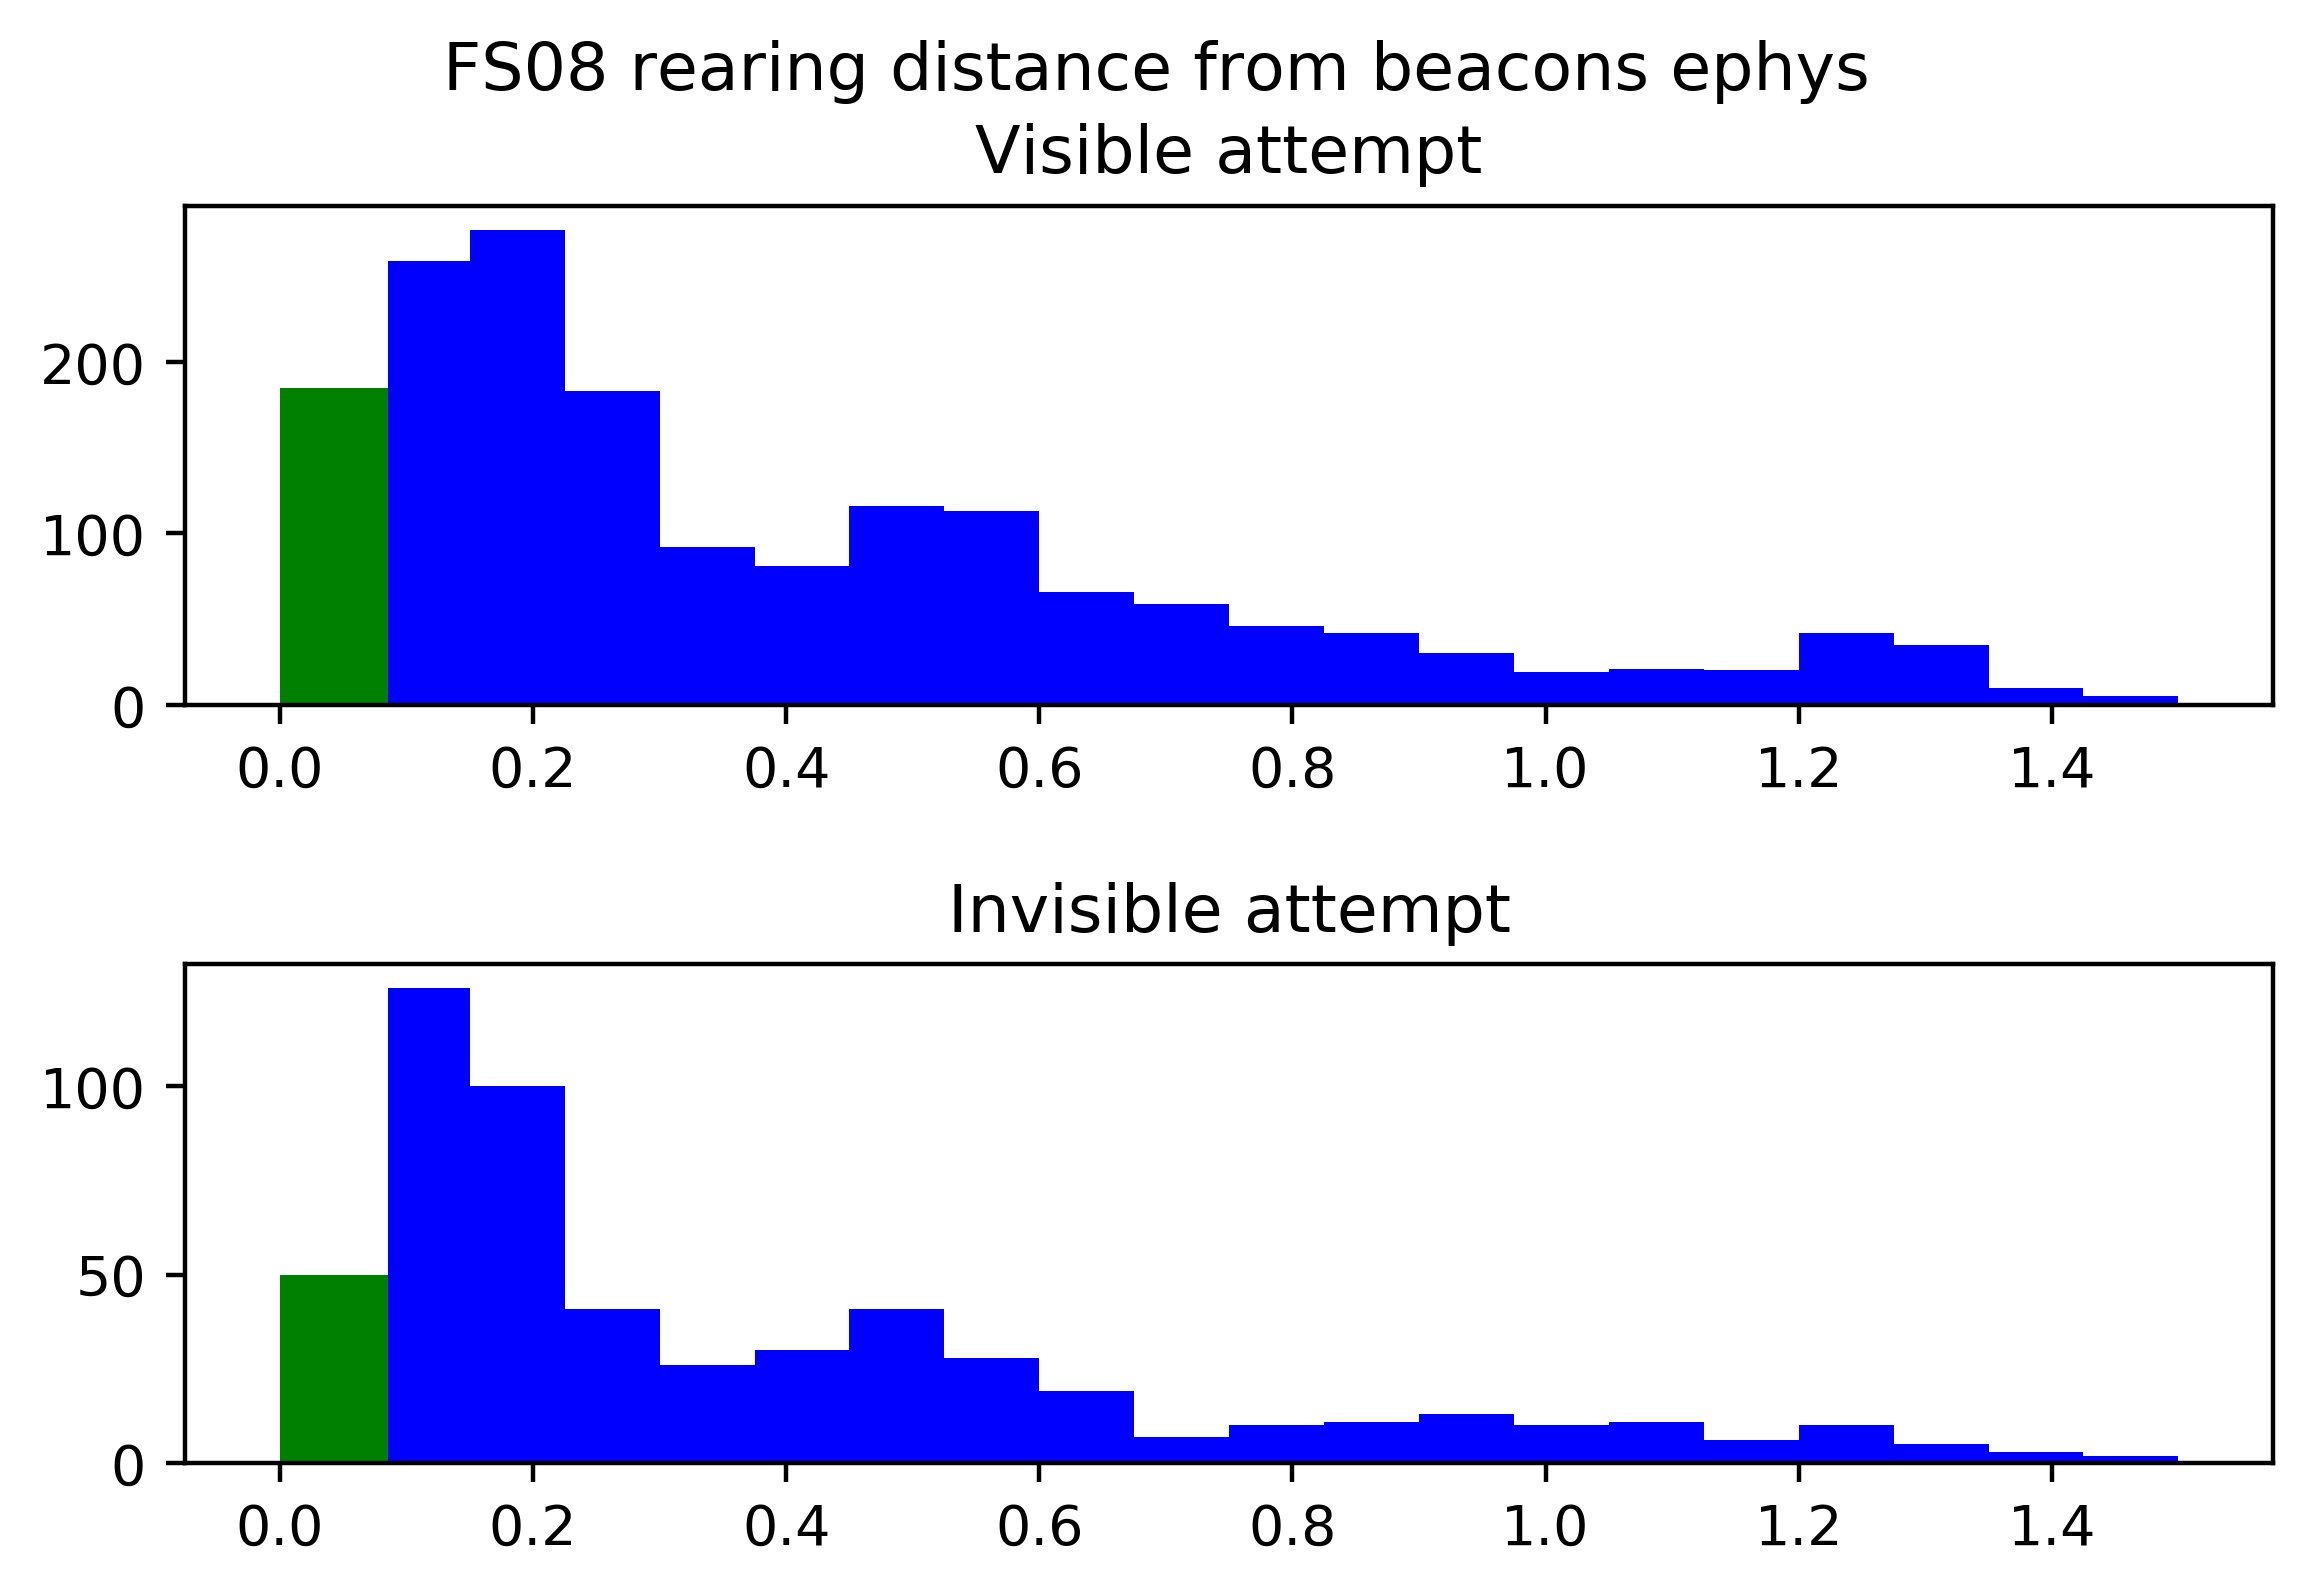

In [58]:
def make_simple_graphs (animal_ID,rearing):
    binwidth=.075
    plt.tight_layout
    bins = np.arange(0, 1.5 + binwidth, binwidth)
    bins[1]= 0.085
    fig, ax = plt.subplots(2,dpi=400,sharex=False)
    fig.suptitle(animal_ID +' rearing distance from beacons ephys',y=1)

    N, bins, patches=ax[0].hist(get_rear_distance_from_beacon(rearing.loc[rearing['Visibility']==1]),bins=bins)
    ax[0].set_title('Visible attempt')
    for i in range(0,1):
        patches[i].set_facecolor('g')
    for i in range(1, len(patches)):
        patches[i].set_facecolor('blue')
        fig.tight_layout(pad=1.5)
        
    N, bins, patches=ax[1].hist(get_rear_distance_from_beacon(rearing.loc[rearing['Visibility']==0]),bins=bins)
    ax[1].set_title('Invisible attempt')
    for i in range(0,1):
        patches[i].set_facecolor('g')
    for i in range(1, len(patches)):
        patches[i].set_facecolor('blue')
        fig.tight_layout(pad=1.5)
    plt.savefig('%srat_rearing_distance_from_beacons_simple%s.png'%(figures,animal_ID), dpi = 100)

    
make_simple_graphs('FS08' ,rearing_FS08) 

# GRAVEYARD`

## Try to catch so that it is the smallest value int the beacon 

In [17]:
df_rears = Z_points
Xs=[]
Ys=[]
for row in Z_points.iterrows():
    #print(row[1][0])

    k = FS03_beacon.iloc[(FS03_beacon[0] - row[1][0]).abs().argsort()[:1]]
    #print(k.values[0][4])
    

    timept = k.values[0][0]
    while timept > row[1][0] and k.index>0:
        
        timept = k.values[0][0]
        k_idx = k.index
        k = FS03_beacon.iloc[k_idx-1] 
        
    Xs.append(k.values[0][4])
    Ys.append(k.values[0][5])


    #print(FS03_position[0][list(k.index)])
    #pos_index.append(int(''.join(map(str,list(k.index)))))
df_rears[4]=Xs
df_rears[5]=Ys
#df_rears

In [18]:
pos_index=[]
invis=[]
#for ind in FS03_beacon.index:
df = FS03_beacon[0].diff().to_frame()
for ind in df.index:
    if df[0][ind]<60 and not (ind % 2 == 0):
        invis.append(ind)
        #print(FS03_beacon[0][ind])
        k = FS03_position.iloc[(FS03_position[0] - FS03_beacon[0][ind]).abs().argsort()[:1]]
        #print(list(k.index))
        #print(FS03_position[0][list(k.index)])
        pos_index.append(int(''.join(map(str,list(k.index)))))
invis
pos_index

[11402, 23433, 56610, 70657, 105457]

In [19]:
pos_index=[]
invis=[]
#for ind in FS03_beacon.index:
df = FS03_beacon[0].diff().to_frame()
for ind in df.index:
    if df[0][ind]<60 and not (ind % 2 == 0):
        invis.append(ind)
        #print(FS03_beacon[0][ind])
        k = Z_points.iloc[(Z_points[0] - FS03_beacon[0][ind]).abs().argsort()[:1]]
        #print(list(k.index))
        #print(FS03_position[0][list(k.index)])
        pos_index.append(int(''.join(map(str,list(k.index)))))
invis
pos_index

[11, 23, 59, 77, 100]

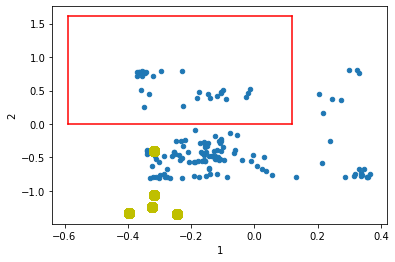

areas: -1.1431


In [78]:
cut=0
Z_points.plot.scatter(x=1, y=2)
plt.plot([(X_cut_min+cut),(X_cut_max-cut)],[(Y_cut_max-cut),(Y_cut_max-cut)] ,'r-')
plt.plot([(X_cut_min+cut),(X_cut_min+cut)],[(Y_cut_min+cut),(Y_cut_max-cut)] ,'r-')
plt.plot([(X_cut_max-cut),(X_cut_max-cut)],[(Y_cut_min+cut),(Y_cut_max-cut)] ,'r-')
plt.plot([(X_cut_max-cut),(X_cut_min+cut)],[(Y_cut_min+cut),(Y_cut_min+cut)] ,'r-')
plt.plot(rr[4]+x_offset,rr[5]-y_offset,'yo',ms=10)

plt.savefig('%srears_all.png' %(figures), dpi = 200) 

plt.show()
print ('areas: %s' %((X_cut_min-X_cut_max)*(Y_cut_max-Y_cut_min))) 

In [ ]:
# def invis_unsucc(rearing):  
#     unsucc = []
#     #look for when beacon changed to get time stamp
#     rearing[8] = rearing[6].shift() != rearing[6]
# #rearing[9] = rearing[0].diff().to_frame()

#     #find if it is true that new beacon appeared and calculated differecne from that number to each subsequent beacon. 
#     time = rearing[0][0]
#     #print(time)
#     for index,row in rearing.iterrows():
#         if row[8] == True:
#             last = row[0]
#             unsucc.append(last)
#             time=last
#         else: 
#             unsucc.append(last)
#     rearing[9]=unsucc
#     #now fill the column with the times 
#     unsucc_time=[]
#     for index,row in rearing.iterrows():
#         unsucc_time.append(row[0]-row[9])
#     rearing[10]= unsucc_time
#     #if that number is not zero and under 60 seconds when time out appears assign #3- as unnsuccesul 
#     # and is above 60 then it is visible again. 
#     threes=[]
#     for index,row in rearing.iterrows():
#         if row[6] == 0 and 0<row[10]<60:
#             threes.append(3)  
#             #print('normal')
#         elif row[6] == 0 and row[10]>60:
#              threes.append(1)      
#             #print('over')
#         else: 
#             threes.append(row[6])
#             #print('nothing')
#     print(len(threes))
#     rearing[6]=threes
#     return rearing
# invis_unsucc(rearing)
# rearing

In [150]:
rearing = beacon_group(rearing)
change = rearing[7]
rearing.drop(labels=['Mid'], axis=1,inplace = True)
rearing.insert(7, 'Change', change)
rearing.head()

D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

KeyError: "['Mid'] not found in axis"

In [152]:
def vis_invis_metadata(beacon,light_off=4):
    """ Add 6th column to beacon file if visible or not"""
    visibility = np.array(beacon.index)
    visibility = np.where(visibility % light_off == 0 , 0, visibility) #### to do list comprehension
    print(visibility)
    beacon[6]=visibility
    return beacon
FS03_beacon=vis_invis_metadata(FS03_beacon) 
FS03_beacon.head(10)

[ 0  1  2  3  0  5  6  7  0  9 10 11  0 13 14 15  0 17 18 19  0 21 22 23
  0 25 26 27  0 29 30 31  0 33 34 35  0 37 38 39  0 41 42 43  0 45 46 47
  0]


,0,1,2,3,4,5,6
0,1615566511.420,-0.403,0.693,0.304,-0.177,-0.524,0
1,1615566575.040,-0.477,0.689,0.286,-0.177,-0.524,1
2,1615566591.520,-0.486,0.660,0.339,-0.177,-0.524,2
3,1615566654.670,-0.436,0.699,0.326,-0.177,-0.524,3
4,1615566660.580,-0.432,0.723,0.291,-0.177,-0.524,0
5,1615566694.100,-0.451,0.713,0.367,-0.177,-0.524,5
6,1615566699.110,-0.424,0.694,0.267,-0.177,-0.524,6
7,1615566761.100,-0.441,0.697,0.272,-0.177,-0.524,7
8,1615566770.400,-0.480,0.689,0.324,-0.177,-0.524,0
9,1615566833.340,-0.449,0.693,0.280,-0.177,-0.524,9
